In [1]:
# Importing the requisite libraries
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import requests
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Creating path to the project directory
project_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'crescent-mountain-fire')

# Creating the project directory
os.makedirs(project_dir, exist_ok=True)
project_dir

'/home/jovyan/earth-analytics/data/crescent-mountain-fire'

In [3]:
# Extract GeoDataFrame from the web link
crescent_mtn_gdf = gpd.read_file("https://services3.arcgis.com/T4QMspbfLg3q"
                            "TGWY/arcgis/rest/services/Historic_Geomac_P"
                            "erimeters_2018/FeatureServer/0/query?where="
                            "incidentname%20%3D%20%27CRESCENT%20MOUNTAIN"
                            "%27%20AND%20latest%20%3D%20%27Y%27&outFields"
                            "=*&outSR=4326&f=json")
crescent_mtn_gdf

,OBJECTID,agency,comments,active,mapmethod,datecurrent,uniquefireidentifier,fireyear,incidentname,pooownerunit,...,incomplex,complexfirecode,mergeid,latest,modifiedon,createdon,temp,shape__Area,shape__Length,geometry
0,4119,USFS,,N,Infrared Image,1540857600000,2018-WAOWF-000428,2018,CRESCENT MOUNTAIN,WAOWF,...,N,,,Y,NaN,NaN,NaN,4.829164e+08,437074.605609,"MULTIPOLYGON (((-120.54069 48.48590, -120.5405..."


## Crescent Mountain Wildfire near Twisp, WA
The Crescent Mountain Fire started on July 29, 2018 approximately 20 miles west of Twisp WA, due to a lightning strike. Several other fires started nearby, which were managed by the same Incident Command team based out of Winthrop WA. The fire burned a total of 52,609 acres of heavily timbered mountain terrain. The area is know for its natural beauty and for the fruit orchards along the Methow river near its confluence with the Columbia River.

In [4]:
# Loading the area base map
crescent_mtn_map = folium.Map(location=[48.3583319,-120.118499526], zoom_start=10)

# Adding location marker for Paradise, CA
folium.Marker(
    [48.3583319,-120.118499526],
    tooltip="Twisp, WA"
).add_to(crescent_mtn_map)

# Loading fire perimeter
folium.GeoJson(
    crescent_mtn_gdf,
    name='fire_perimeter_layer'
).add_to(crescent_mtn_map)

crescent_mtn_map

In [5]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key='modis-ndvi',
    ea_dir=project_dir,
    product='MYD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date='06-01',
    end_date='08-31',
    recurring=True,
    year_range=[2017, 2022],
    polygon=crescent_mtn_gdf
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

# ndvi_downloader

In [6]:
# Loading .tif files in python
ndvi_path_list = sorted(glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))
)

# ndvi_path_list

In [7]:
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_das = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_das.append(da)

# ndvi_das

In [8]:
# Creating Time Series by date
ndvi_ds = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_ds

<xarray.Dataset>
Dimensions:      (x: 158, y: 108, date: 41)
Coordinates:
    band         int64 1
  * x            (x) float64 -120.6 -120.6 -120.6 ... -120.3 -120.3 -120.3
  * y            (y) float64 48.5 48.49 48.49 48.49 ... 48.28 48.28 48.28 48.27
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2017-05-17 2017-06-02 ... 2022-08-21
Data variables:
    NDVI         (date, y, x) float32 0.0321 -0.0573 -0.0201 ... 0.8012 0.8027

## NDVI change over time 2017-2019
THis map shows the change in NDVI data from 2017 pre-fire, to 2019 post-fire. It is clear from the map that the fire caused significant impacts to the vegetation and forest health inside the fire boundary.

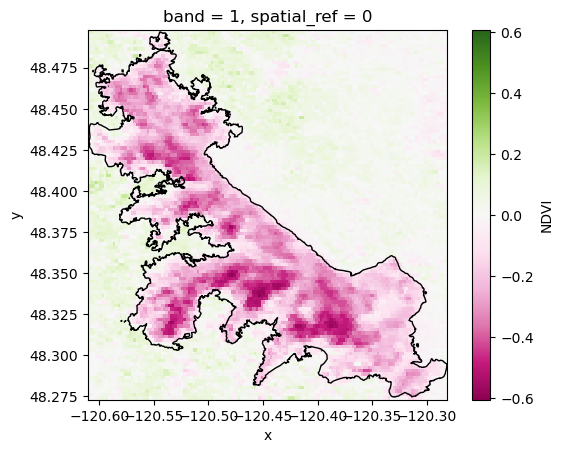

In [9]:
import matplotlib.pyplot as plt
# Plotting change in NDVI over time
dndvi_da = (ndvi_ds
        .sel(date='2019',)
        .mean('date')
        .NDVI
    - ndvi_ds
        .sel(date='2017',)
        .mean('date')
        .NDVI
)

dndvi_da.plot(cmap=plt.colormaps['PiYG'])
crescent_mtn_gdf.plot(facecolor='none',  ax=plt.gca())

plt.show()

In [10]:
# Compare the area in/out of fire boundary
out_gdf = (
    gpd.GeoDataFrame(geometry=crescent_mtn_gdf.envelope)
    .overlay(crescent_mtn_gdf, how="difference")
)

out_gdf

,geometry
0,"MULTIPOLYGON (((-120.60954 48.43019, -120.6095..."


In [11]:
# Clipping the areas inside and outside the fire boundary
ndvi_fire_da = ndvi_ds.rio.clip(crescent_mtn_gdf.geometry)
ndvi_out_da = ndvi_ds.rio.clip(out_gdf.geometry)

In [12]:
# Find the yearly mean NDVI inside and outside fire boundary
inside_df = ndvi_fire_da.groupby('date.year').mean(...).NDVI.to_dataframe()

outside_df = ndvi_out_da.groupby('date.year').mean(...).NDVI.to_dataframe()

inside_df, outside_df

(      band  spatial_ref      NDVI
 year                             
 2017     1            0  0.675163
 2018     1            0  0.631199
 2019     1            0  0.447035
 2020     1            0  0.501148
 2021     1            0  0.517128
 2022     1            0  0.497369,
       band  spatial_ref      NDVI
 year                             
 2017     1            0  0.537322
 2018     1            0  0.546438
 2019     1            0  0.563249
 2020     1            0  0.554804
 2021     1            0  0.529473
 2022     1            0  0.483290)

## Significant Impact to Vegetation in Crescent Mountain Wildfire Burn Zone
The plot shows the difference in NDVI for the Crescent Mountain Fire burn area and its surrounding from 2017, before the fire through 2022, 4 years after the fire. The plot shows significant recovery of vegetation health, but still a marked disparity between pre-fire vegetation health and post-fire vegetation health. 

<Axes: xlabel='year', ylabel='Difference in NDVI'>

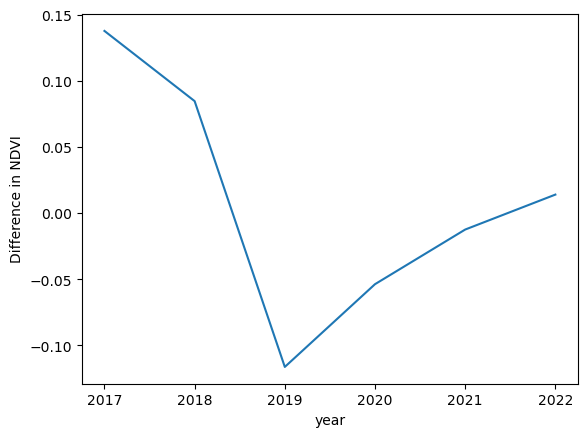

In [13]:
# Finding the difference in NVDI in/out of fire boundary over time
ndvi_diff_df = inside_df.NDVI - outside_df.NDVI
ndvi_diff_df

# Plot showing NDVI Difference
ndvi_diff_df.plot(
    xlabel='year', ylabel='Difference in NDVI'
)

### Data Source
The data was collected by Nasa's Aqua MODIS platform, and accessed through the APPEEARS API.
Didan, K. (2021). MODIS/Aqua Vegetation Indices 16-Day L3 Global 250m SIN Grid V061. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-10-05 from https://doi.org/10.5067/MODIS/MYD13Q1.061. Accessed October 5, 2023.

In [15]:
%%capture
%%bash
jupyter nbconvert crescent-mtn-fire-raster-data.ipynb --to html --no-input